# Library Management Notebook

This notebook provides interactive tools for managing a small library using CSV files. It loads `books`, `authors`, `members`, and `borrowingrecords` CSVs (if present), offers search and borrow/return simulations, runs analysis, and exports updated CSVs.

**Requirements:** `pandas`, `ipywidgets`, `matplotlib`.

Run the cells in order.

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from IPython.display import display, clear_output
import ipywidgets as widgets

DATA_DIR = './CSVFiles'  # adjust if needed

def safe_read_csv(path):
    if os.path.exists(path):
        return pd.read_csv(path)
    else:
        return None


In [ ]:
# Paths (change if your files are elsewhere)

books_path = os.path.join(DATA_DIR, 'library_books.csv')
authors_path = os.path.join(DATA_DIR, 'library_authors.csv')
members_path = os.path.join(DATA_DIR, 'library_members.csv')
borrows_path = os.path.join(DATA_DIR, 'library_borrowingrecords.csv')

books = safe_read_csv(books_path)
authors = safe_read_csv(authors_path)
members = safe_read_csv(members_path)
borrows = safe_read_csv(borrows_path)

# If any CSV is missing, generate small sample data so the notebook still runs
if books is None:
    books = pd.DataFrame([
        [1, "To Kill a Mockingbird", 101, "Fiction", 1960, 4],
        [2, "1984", 102, "Dystopian", 1949, 6],
        [3, "Pride and Prejudice", 103, "Romance", 1813, 3],
        [5, "Moby Dick", 105, "Adventure", 1851, 2],
        [9, "The Hobbit", 109, "Fantasy", 1937, 8],
        [14, "The Odyssey", 113, "Epic", -800, 3],
        [18, "Harry Potter and the Sorcerer's Stone", 115, "Fantasy", 1997, 10]
    ], columns=['bookid','title','authorid','genre','publishedyear','quantity'])
    print('books.csv not found — loaded sample books.')

if authors is None:
    authors = pd.DataFrame([
        [101, 'Harper', 'Lee', 'American'],
        [102, 'George', 'Orwell', 'British'],
        [103, 'Jane', 'Austen', 'British'],
        [109, 'J.R.R.', 'Tolkien', 'British'],
        [115, 'J.K.', 'Rowling', 'British']
    ], columns=['authorid','firstname','lastname','nationality'])
    print('authors.csv not found — loaded sample authors.')

if members is None:
    members = pd.DataFrame([
        [201, 'John', 'Smith', '2022-03-15', 5],
        [202, 'Emma', 'Johnson', '2022-07-10', 8],
        [203, 'Liam', 'Brown', '2023-01-20', 3],
        [204, 'Olivia', 'Taylor', '2022-11-05', 7],
        [205, 'Noah', 'Anderson', '2023-06-14', 4]
    ], columns=['memberid','firstname','lastname','membershipdate','booksborrowed'])
    print('members.csv not found — loaded sample members.')

if borrows is None:
    borrows = pd.DataFrame([
        [1,201,1,'2024-09-13','2024-09-29'],
        [2,202,2,'2024-10-04','2024-10-19'],
        [3,203,3,'2024-03-08','2024-03-21'],
        [4,204,5,'2024-04-15','2024-04-28'],
        [5,205,9,'2024-05-02','2024-05-17']
    ], columns=['recordId','memberid','bookid','borrowdate','returndate'])
    print('borrowingrecords.csv not found — loaded sample borrowing records.')

# normalize column names
books.columns = books.columns.str.strip()
authors.columns = authors.columns.str.strip()
members.columns = members.columns.str.strip()
borrows.columns = borrows.columns.str.strip()

# ensure date columns as datetime
for col in ['borrowdate','returndate']:
    if col in borrows.columns:
        borrows[col] = pd.to_datetime(borrows[col])

display(books.head())
display(authors.head())
display(members.head())
display(borrows.head())

,bookid,title,authorid,genre,publishedyear,quantity
0,1,To Kill a Mockingbird,101,Fiction,1960,4
1,2,1984,102,Dystopian,1949,6
2,3,Pride and Prejudice,103,Romance,1813,3
3,4,The Great Gatsby,104,Fiction,1925,5
4,5,Moby Dick,105,Adventure,1851,2


,authorid,firstname,lastname,nationality
0,101,Harper,Lee,American
1,102,George,Orwell,British
2,103,Jane,Austen,British
3,104,F. Scott,Fitzgerald,American
4,105,Herman,Melville,American


,memberid,firstname,lastname,membershipdate,booksborrowed
0,201,John,Smith,2022-03-15,5
1,202,Emma,Johnson,2022-07-10,8
2,203,Liam,Brown,2023-01-20,3
3,204,Olivia,Taylor,2022-11-05,7
4,205,Noah,Anderson,2023-06-14,4


,recordId,memberid,bookid,borrowdate,returndate
0,1,207,5,2025-01-03,2025-01-15
1,2,219,9,2025-02-10,2025-02-25
2,3,203,18,2025-03-05,2025-03-20
3,4,210,1,2025-01-14,2025-01-29
4,5,229,5,2025-04-07,2025-04-19


In [4]:
def save_all():
    books.to_csv(books_path, index=False)
    authors.to_csv(authors_path, index=False)
    members.to_csv(members_path, index=False)
    borrows.to_csv(borrows_path, index=False)
    print('Saved CSVs to', DATA_DIR)

In [ ]:
# Interactive search for books

search_text = widgets.Text(description='Search:', placeholder='title, author, genre or id')
out = widgets.Output()

def search_books(change):
    q = change['new']
    with out:
        clear_output()
        if q.strip() == '':
            display(books.head(20))
            return
        qlow = q.lower()
        mask = books['title'].astype(str).str.lower().str.contains(qlow) | books['genre'].astype(str).str.lower().str.contains(qlow) | books['bookid'].astype(str).str.contains(qlow)
        # join to authors for author name search
        merged = books.merge(authors, on='authorid', how='left')
        mask = mask | merged['firstname'].astype(str).str.lower().str.contains(qlow) | merged['lastname'].astype(str).str.lower().str.contains(qlow)
        display(merged[mask].reset_index(drop=True).head(50))

search_text.observe(search_books, names='value')
display(search_text, out)

Text(value='', description='Search:', placeholder='title, author, genre or id')

Output()

In [ ]:
# Borrow simulation UI

member_input = widgets.BoundedIntText(min=100, max=9999, description='MemberID:')
book_input = widgets.BoundedIntText(min=1, max=99999, description='BookID:')
borrow_button = widgets.Button(description='Borrow')
borrow_out = widgets.Output()

def borrow_action(btn):
    with borrow_out:
        clear_output()
        mid = int(member_input.value)
        bid = int(book_input.value)
        if mid not in members['memberid'].values:
            print('Member not found:', mid); return
        if bid not in books['bookid'].values:
            print('Book not found:', bid); return
        # check availability: quantity - currently borrowed
        today = pd.Timestamp.now().normalize()
        currently_out = borrows[borrows['returndate'] >= today][borrows['bookid']==bid]
        out_count = currently_out.shape[0]
        available = int(books.loc[books['bookid']==bid,'quantity'].iloc[0]) - out_count
        if available <= 0:
            print('No copies available for book', bid); return
        # create record
        new_id = int(borrows['recordId'].max())+1 if not borrows.empty else 1
        borrow_date = pd.Timestamp.now().normalize()
        ret_date = borrow_date + pd.Timedelta(days=14)
        borrows.loc[len(borrows)] = [new_id, mid, bid, borrow_date, ret_date]
        members.loc[members['memberid']==mid,'booksborrowed'] += 1
        print(f'Borrowed book {bid} to member {mid}. Due on', ret_date.date())
        save_all()

borrow_button.on_click(borrow_action)
display(widgets.HBox([member_input, book_input, borrow_button]), borrow_out)

Output()

In [ ]:
# Return simulation UI

record_input = widgets.BoundedIntText(min=1, max=999999, description='RecordID:')
return_button = widgets.Button(description='Return')
return_out = widgets.Output()

def return_action(btn):
    with return_out:
        clear_output()
        rid = int(record_input.value)
        if rid not in borrows['recordId'].values:
            print('Record not found:', rid); return
        # mark actual return by setting returndate to now (assumes returndate was planned)
        idx = borrows.index[borrows['recordId']==rid][0]
        actual = pd.Timestamp.now().normalize()
        borrows.at[idx,'returndate'] = actual
        mid = int(borrows.at[idx,'memberid'])
        members.loc[members['memberid']==mid,'booksborrowed'] -= 1
        print(f'Record {rid} returned on', actual.date())
        save_all()

return_button.on_click(return_action)
display(widgets.HBox([record_input, return_button]), return_out)

Output()

Top borrowed books:


,bookid,borrow_count,title
0,5,8,Moby Dick
1,9,5,The Hobbit
2,1,5,To Kill a Mockingbird
3,18,4,Harry Potter and the Sorcerer's Stone
4,2,1,1984
5,14,1,The Odyssey
6,6,1,War and Peace
7,10,1,Crime and Punishment
8,4,1,The Great Gatsby
9,12,1,Wuthering Heights



Most active members:


,memberid,borrow_count,firstname,lastname
0,205,2,Noah,Anderson
1,216,2,Amelia,Rodriguez
2,203,1,Liam,Brown
3,210,1,Isabella,Martin
4,229,1,Joseph,Nelson
5,207,1,William,Jackson
6,212,1,Mia,Garcia
7,224,1,Ella,Wright
8,215,1,Henry,Clark
9,218,1,Harper,Lee



Availability snapshot:


,bookid,title,quantity,out_count,available
0,1,To Kill a Mockingbird,4,2,2
1,2,1984,6,0,6
2,3,Pride and Prejudice,3,0,3
3,4,The Great Gatsby,5,0,5
4,5,Moby Dick,2,1,1
5,6,War and Peace,4,0,4
6,7,The Catcher in the Rye,7,0,7
7,8,Brave New World,3,0,3
8,9,The Hobbit,8,0,8
9,10,Crime and Punishment,5,0,5



Overdue list:


,recordId,memberid,firstname,lastname,bookid,title,borrowdate,returndate
0,1,207,William,Jackson,5,Moby Dick,2025-01-03,2025-01-15
1,2,219,Ethan,Walker,9,The Hobbit,2025-02-10,2025-02-25
2,3,203,Liam,Brown,18,Harry Potter and the Sorcerer's Stone,2025-03-05,2025-03-20
3,5,229,Joseph,Nelson,5,Moby Dick,2025-04-07,2025-04-19
4,6,212,Mia,Garcia,9,The Hobbit,2025-03-25,2025-04-08
5,7,205,Noah,Anderson,5,Moby Dick,2025-05-02,2025-05-15
6,8,224,Ella,Wright,18,Harry Potter and the Sorcerer's Stone,2025-01-27,2025-02-12
7,9,215,Henry,Clark,1,To Kill a Mockingbird,2025-02-15,2025-02-28
8,10,218,Harper,Lee,5,Moby Dick,2025-03-02,2025-03-15
9,11,226,Elizabeth,Green,9,The Hobbit,2025-05-05,2025-05-19


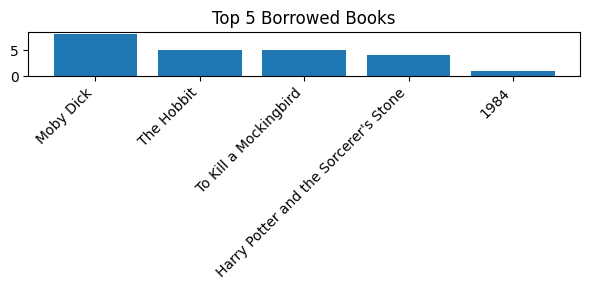

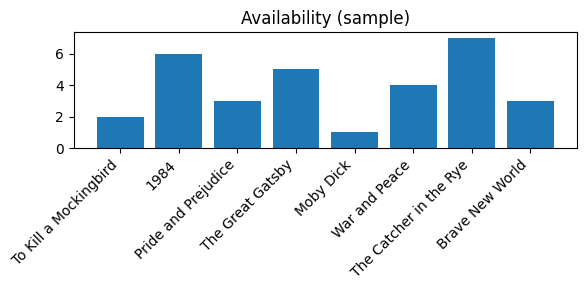

In [8]:
# Analysis reports and visualizations

def top_borrowed_books(n=10):
    counts = borrows['bookid'].value_counts().head(n).reset_index()
    counts.columns = ['bookid','borrow_count']
    return counts.merge(books[['bookid','title']], on='bookid', how='left')

def most_active_members(n=10):
    counts = borrows['memberid'].value_counts().head(n).reset_index()
    counts.columns = ['memberid','borrow_count']
    return counts.merge(members[['memberid','firstname','lastname']], on='memberid', how='left')

def availability():
    # count currently outstanding as those with returndate >= today (planned return or not yet returned)
    today = pd.Timestamp.now().normalize()
    out_now = borrows[borrows['returndate'] >= today].groupby('bookid').size().rename('out_count').reset_index()
    df = books.merge(out_now, on='bookid', how='left')
    df['out_count'] = df['out_count'].fillna(0).astype(int)
    df['available'] = df['quantity'] - df['out_count']
    return df[['bookid','title','quantity','out_count','available']]

def overdue_list():
    # overdue: returndate < today
    today = pd.Timestamp.now().normalize()
    overdue = borrows[borrows['returndate'] < today].merge(books[['bookid','title']], on='bookid', how='left')             .merge(members[['memberid','firstname','lastname']], on='memberid', how='left')
    return overdue[['recordId','memberid','firstname','lastname','bookid','title','borrowdate','returndate']]

# Display
print('Top borrowed books:')
display(top_borrowed_books(10))

print('\nMost active members:')
display(most_active_members(10))

print('\nAvailability snapshot:')
display(availability().head(20))

print('\nOverdue list:')
display(overdue_list().head(20))

# Simple plots (matplotlib only; single plot per cell)
tb = top_borrowed_books(5)
plt.figure(figsize=(6,3))
plt.bar(tb['title'], tb['borrow_count'])
plt.xticks(rotation=45, ha='right')
plt.title('Top 5 Borrowed Books')
plt.tight_layout()
plt.show()

g = availability()
plt.figure(figsize=(6,3))
plt.bar(g['title'][:8], g['available'][:8])
plt.xticks(rotation=45, ha='right')
plt.title('Availability (sample)')
plt.tight_layout()
plt.show()

In [ ]:
# Export current DataFrames to CSVs (overwrite)

save_btn = widgets.Button(description='Save CSVs')
save_out = widgets.Output()

def save_action(btn):
    with save_out:
        clear_output()
        save_all()

save_btn.on_click(save_action)
display(save_btn, save_out)

Button(description='Save CSVs', style=ButtonStyle())

Output()

In [15]:
# Late Returns

borrows['borrowdate'] = pd.to_datetime(borrows['borrowdate'])
borrows['returndate'] = pd.to_datetime(borrows['returndate'])
borrows['due_date'] = borrows['borrowdate'] + pd.Timedelta(days=14)
borrows['late'] = borrows['returndate'] > borrows['due_date']

late_returns = borrows[borrows['late'] == True]
print("\n⚠️ Late Returns:")
print(late_returns.head())


⚠️ Late Returns:
    recordId  memberid  bookid borrowdate returndate   due_date  late
1          2       219       9 2025-02-10 2025-02-25 2025-02-24  True
2          3       203      18 2025-03-05 2025-03-20 2025-03-19  True
3          4       210       1 2025-01-14 2025-08-10 2025-01-28  True
7          8       224      18 2025-01-27 2025-02-12 2025-02-10  True
11        12       201      18 2025-04-13 2025-04-28 2025-04-27  True



🎯 Genre Popularity:
genre
Fantasy          9
Adventure        8
Fiction          7
Dystopian        2
Historical       2
Romance          2
Epic             1
Psychological    1
Name: count, dtype: int64


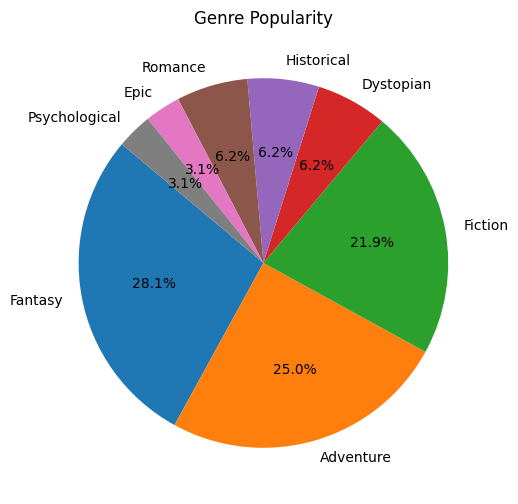

In [ ]:
# Genre popularity using pie chart

borrow_with_genre = borrows.merge(books[['bookid', 'genre']], on='bookid')
genre_count = borrow_with_genre['genre'].value_counts()

print("\n🎯 Genre Popularity:")
print(genre_count)

plt.figure(figsize=(6,6))
plt.pie(genre_count, labels=genre_count.index, autopct='%1.1f%%', startangle=140)
plt.title("Genre Popularity")
plt.show()